In [1]:

import numpy as np
import seaborn as sns
import warnings

from rich import print
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore")

## Fenômeno de Runge (RUGGIERO, 1996. p.p. 266.)

Considere a função $f(x) = \dfrac{1}{1 + 25x^2}$ do Exemplo 12 e o intervalo $[a, b] = [-5, 5]$. O objetivo deste projeto é constatar o fenômeno de Runge e usar as alternativas: spline linear e spline cúbica interpolantes.

Considere:
* $p_n(x)$: polinômio de grau $k$ que interpola $f(x)$ em $x_0, x_1, ..., x_k$;
* $S_1(x)$: spline linear interpolante em $f(x)$ em $x_0, x_1, ..., x_k$;
* $S_3(x)$: spline cúbica interpolante em $x_0, x_1, ..., x_k$;

Onde $x_0, x_1, ..., x_k$ são $(k + 1)$ pontos igualmente espaçados no intervalo $[-5, 5]$.

Realize 3 conjuntos de testes, fazendo $k$ assumir os valores 5, 10 e 20, e em cada teste, calcule:

* $\text{máx}_{1 \le i \le 50} |f(z_i) - p_k(z_i)|$, 
* $\text{máx}_{1 \le i \le 50} |f(x_i) - S_1(z_i)|$, 
* $\text{máx}_{1 \le i \le 50} |f(z_i) - S_3(z_i)|$

onde $z_i = -5 + 0.2i$, $i = 0, 1, 2, ..., 50$.

Compare os resultados obtidos.

### Implementação algoritmica

In [2]:

def polinomio_k(k: int, f, X: np.array, y: np.array, x: float) -> float:

    distancias = np.abs(X - x)
    idx = np.argsort(distancias)[:k + 1]
    _y = y[idx]
    _X = X[idx]

    n = _y.shape[0]
    A = np.zeros((n, k + 1))

    A[:, 0] = 1
    for i in range(1, k + 1):
        A[:, i] = _X ** (i)

    # Utiliza minimos quadrados
    a = np.linalg.lstsq(A, _y, rcond=None)[0]

    r = a[0]
    for i in range(1, k + 1):
        r += a[i] * (x ** i)

    return r


In [3]:

def spline_linear(f, X: np.array, x: float) -> float:
    
    X = np.sort(X)
    i = np.searchsorted(X, x)

    if i == 0: i = 1
    elif i == len(X): i -= 1

    y = (f(X[i - 1]) * ((X[i] - x) / (X[i] - X[i - 1]))) + (f(X[i]) * ((x - X[i - 1]) / (X[i] - X[i - 1]))) 

    return y


In [4]:

def spline_cubica(f, X: np.array, x: float) -> float:
    
    n = len(X) - 1
    h = np.diff(X)
    
    # Matriz tridiagonal para os coeficientes
    A = np.zeros((n+1, n+1))
    b = np.zeros(n+1)
    
    # Preencher as equações para as derivadas segundas
    for i in range(1, n):
        A[i, i-1] = h[i-1]
        A[i, i] = 2 * (h[i-1] + h[i])
        A[i, i+1] = h[i] 
        b[i] = (3 / h[i]) * (f(X[i+1]) - f(X[i])) - (3 / h[i-1]) * (f(X[i]) - f(X[i-1]))

    # Condições da spline natural (segunda derivada zero nos extremos)
    A[0, 0] = 1
    A[n, n] = 1
    
    # Resolver o sistema linear para obter as segundas derivadas
    c = np.linalg.solve(A, b)
    
    # Encontrar o intervalo que contém x
    i = np.searchsorted(X, x) - 1
    if i < 0:
        i = 0
    elif i >= n:
        i = n - 1
    
    # Calcular os coeficientes do polinômio cúbico
    a = f(X[i])
    b = (f(X[i+1]) - f(X[i])) / h[i] - h[i] * (2 * c[i] + c[i+1]) / 3
    d = (c[i+1] - c[i]) / (3 * h[i])
    
    # Calcular o valor da spline cúbica
    dx = x - X[i]
    y = a + b * dx + c[i] * dx**2 + d * dx**3
    
    return y


In [5]:

def calcular_experimento(A: tuple[int, int], k: int) -> dict[str, float]:

    # Implementa a funcao
    # $f(x) = \dfrac{1}{1 + 25x^2}$
    f = lambda x: 1 / (1 + 25 * (x**2))

    # Monta X considerando
    # x_0, x_1, ..., x_k \forall x \in A
    x = np.linspace(*A, k + 1)

    # Monta z considerando
    # z = -5 + 0.2 * i, i = 0, 1, ..., 50.
    z = np.array([-5 + 0.2 * i for i in range(51) if i >= 1], dtype=float)

    # Estima a funcao para z*
    fz = np.apply_along_axis(f, 0, z)

    # Estima o polinomio valores para z*
    pk = np.array([polinomio_k(k, f, x, z, xi) for xi in z], dtype=float)
    s1 = np.array([spline_linear(f, x, xi) for xi in z], dtype=float)
    s3 = np.array([spline_cubica(f, x, xi) for xi in z], dtype=float)

    resultados = {
        r'$p_k$': np.round(np.max(np.abs(fz - pk)), 5),
        r'$S_1$': np.round(np.max(np.abs(fz - s1)), 5),
        r'$S_3$': np.round(np.max(np.abs(fz - s3)), 5)
    }

    return resultados, {'pk': pk, 's1': s1, 's3': s3, 'z': z, 'fz': fz}

### Cálculo do experimento

In [6]:

A = (-5, 5)
ks = [5, 10, 20]

resultados = {}
vetores = {}
for k in ks:
    resultado, vetor = calcular_experimento(A, k)
    resultados[f'Para {k=}'] = resultado
    vetores[f'Para {k=}'] = vetor
    
print(resultados)


{
    'Para k=5': {'$p_k$': 5.3, '$S_1$': 0.96154, '$S_3$': 0.95493},
    'Para k=10': {'$p_k$': 4.8, '$S_1$': 0.41538, '$S_3$': 0.53728},
    'Para k=20': {'$p_k$': 222.77242, '$S_1$': 0.15517, '$S_3$': 0.26841}
}

Percebe-se um desempenho relativamente melhor da interpolação por spline linear quando $k \ge 10$. Apenas quando $k \le 5$, a interpolação por spline cúbica se demonstrou a melhor opção. 

Em todos os casos, a interpolação linear não foi suficiente para realizar a leitura, o que evidencia o fenômeno de Runge.

Na comparação gráfica da sequência, é possível notar visivelmente este fenômeno.


### Comparação dos resultados

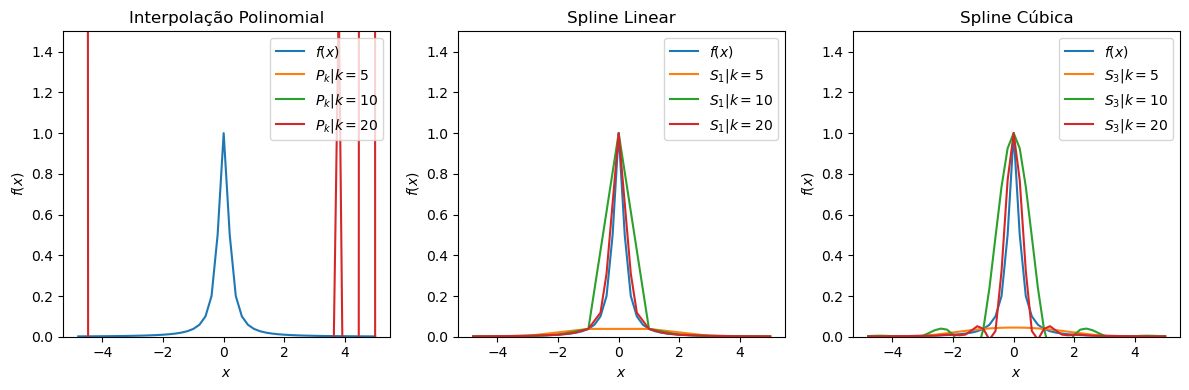

In [7]:
# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Third plot - Interpolação polinomial
sns.lineplot(ax=axes[0], x=vetores['Para k=5']['z'], y=vetores['Para k=5']['fz'], label=r'$f(x)$')
sns.lineplot(ax=axes[0], x=vetores['Para k=20']['z'], y=vetores['Para k=5']['pk'], label=r'$P_k | k = 5$')
sns.lineplot(ax=axes[0], x=vetores['Para k=20']['z'], y=vetores['Para k=10']['pk'], label=r'$P_k | k = 10$')
sns.lineplot(ax=axes[0], x=vetores['Para k=20']['z'], y=vetores['Para k=20']['pk'], label=r'$P_k | k = 20$')
axes[0].set_ylim((0, 1.5))
axes[0].set_xlabel(r'$x$')
axes[0].set_ylabel(r'$f(x)$')
axes[0].set_title('Interpolação Polinomial')


# Second plot - Spline Linear
sns.lineplot(ax=axes[1], x=vetores['Para k=5']['z'], y=vetores['Para k=5']['fz'], label=r'$f(x)$')
sns.lineplot(ax=axes[1], x=vetores['Para k=20']['z'], y=vetores['Para k=5']['s1'], label=r'$S_1 | k = 5$')
sns.lineplot(ax=axes[1], x=vetores['Para k=20']['z'], y=vetores['Para k=10']['s1'], label=r'$S_1 | k = 10$')
sns.lineplot(ax=axes[1], x=vetores['Para k=20']['z'], y=vetores['Para k=20']['s1'], label=r'$S_1 | k = 20$')
axes[1].set_ylim((0, 1.5))
axes[1].set_xlabel(r'$x$')
axes[1].set_ylabel(r'$f(x)$')
axes[1].set_title('Spline Linear')

# First plot - Spline Cúbica
sns.lineplot(ax=axes[2], x=vetores['Para k=5']['z'], y=vetores['Para k=5']['fz'], label=r'$f(x)$')
sns.lineplot(ax=axes[2], x=vetores['Para k=20']['z'], y=vetores['Para k=5']['s3'], label=r'$S_3 | k = 5$')
sns.lineplot(ax=axes[2], x=vetores['Para k=20']['z'], y=vetores['Para k=10']['s3'], label=r'$S_3 | k = 10$')
sns.lineplot(ax=axes[2], x=vetores['Para k=20']['z'], y=vetores['Para k=20']['s3'], label=r'$S_3 | k = 20$')
axes[2].set_ylim((0, 1.5))
axes[2].set_xlabel(r'$x$')
axes[2].set_ylabel(r'$f(x)$')
axes[2].set_title('Spline Cúbica')


# Adjust layout
plt.tight_layout()
plt.show()

Assim, fica evidenciado o fenômeno notado, bem como a supremacia da Spline Linear frente à cúbica quando $k$ é suficientemente grande e a supremacia da spline cúbica para baixos valores de $k$. Também, as limitações da interpolação polinomial, principalmente com altos graus de polinômios.